In [1]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 7.6 MB/s eta 0:00:00


In [18]:
import pandas as pd
import numpy as np
import tqdm
import torch
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from torch.utils.data.sampler import SubsetRandomSampler
import time
import matplotlib.pyplot as plt
import torchmetrics
import torch.nn as nn
from sklearn.feature_selection import r_regression
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
gi_data = pd.read_csv("/content/drive/MyDrive/GI_Project/gi_data.csv", delimiter="\t")

In [5]:
foodData = pd.read_csv(f"/content/drive/MyDrive/GI_Project/NutritionDataUsdaGiMatched.csv")
foodData['GI'] = gi_data['GI']
# Drop all columns with 50% or more NaN values
foodData = foodData.dropna(thresh=foodData.shape[0]*0.5, axis=1)
# Drop all rows without at least 80% non NaN data
foodData = foodData.dropna(thresh=foodData.shape[1]*0.8, axis=0)
foodData

,gi_name,usda_name,score,fdc_id,Protein [G],Total lipid (fat) [G],"Carbohydrate, by difference [G]",Energy [KCAL],"Fiber, total dietary [G]","Calcium, Ca [MG]","Iron, Fe [MG]","Sodium, Na [MG]","Vitamin A, IU [IU]","Vitamin C, total ascorbic acid [MG]",Cholesterol [MG],"Fatty acids, total trans [G]","Fatty acids, total saturated [G]","Sugars, total including NLEA [G]",GI
0,"Cake, NS, decreased GI variant, sugar-to-flour...",Morrison's Hi Ratio Cake Flour,27.767183,2492814,6.67,0.00,80.00,367.0,3.3,0.0,4.67,0.0,NaN,NaN,0.0,0.00,0.00,0.00,20
1,"Carrot cake, prepared with wheat flour and coc...","COCONUT CARROT CAKE VEGAN MUFFIN, COCONUT CARR...",30.056784,2077739,3.64,16.36,56.36,382.0,1.8,15.0,0.00,309.0,NaN,NaN,0.0,0.00,3.64,32.73,37
2,Chocolate cake made from packet mix with choco...,CHOCOLATE CAKE MIX,30.066408,1860807,6.98,2.33,81.40,356.0,5.8,23.0,1.67,458.0,0.0,0.0,0.0,0.00,2.33,37.21,38
3,Chocolate mudcake,CHOCOLATE CHEESECAKE,33.959480,1665581,5.05,24.24,34.34,374.0,1.0,48.0,2.02,232.0,NaN,NaN,66.0,0.51,12.12,23.23,43
4,Christmas fruit cake,CHRISTMAS CAKE,35.892059,2484307,0.33,0.11,3.86,29.0,0.1,3.0,0.12,24.0,NaN,NaN,4.0,0.00,0.22,2.10,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4227,"Wholemeal bread (85 g), consumed with boiled e...",BREAD & 70% DARK CHOCOLATE,24.796761,2136799,7.55,35.85,49.06,472.0,9.4,0.0,2.04,179.0,0.0,0.0,0.0,0.00,20.75,28.30,55
4228,ZANHUO/ManaGI Egg Yolk Pastry,"APOLLO, FILLO PHYLLO PASTRY SHEETS",27.676426,1477116,8.33,3.12,54.17,271.0,2.1,0.0,0.75,750.0,0.0,0.0,0.0,0.00,0.00,2.08,28
4229,ZANHUO/ManaGI Matcha Crispbread,"CRISPBREAD, SESAME",30.705032,2024296,14.81,11.11,66.67,370.0,7.4,148.0,2.67,444.0,0.0,0.0,0.0,0.00,0.00,0.00,53
4230,ZANHUO/ManaGI Oat Bread (Americano Flavor),COUNTRY OAT BREAD MIX,30.381863,2011686,6.98,2.33,79.07,372.0,7.0,0.0,1.26,507.0,0.0,0.0,0.0,0.00,2.33,6.98,42


In [6]:
# Missing value imputation by average. IDK if this is the best way

for column in foodData.columns[4:]:
    foodData[column] = foodData[column].fillna(0)#foodData[column].mean())
foodData

,gi_name,usda_name,score,fdc_id,Protein [G],Total lipid (fat) [G],"Carbohydrate, by difference [G]",Energy [KCAL],"Fiber, total dietary [G]","Calcium, Ca [MG]","Iron, Fe [MG]","Sodium, Na [MG]","Vitamin A, IU [IU]","Vitamin C, total ascorbic acid [MG]",Cholesterol [MG],"Fatty acids, total trans [G]","Fatty acids, total saturated [G]","Sugars, total including NLEA [G]",GI
0,"Cake, NS, decreased GI variant, sugar-to-flour...",Morrison's Hi Ratio Cake Flour,27.767183,2492814,6.67,0.00,80.00,367.0,3.3,0.0,4.67,0.0,0.0,0.0,0.0,0.00,0.00,0.00,20
1,"Carrot cake, prepared with wheat flour and coc...","COCONUT CARROT CAKE VEGAN MUFFIN, COCONUT CARR...",30.056784,2077739,3.64,16.36,56.36,382.0,1.8,15.0,0.00,309.0,0.0,0.0,0.0,0.00,3.64,32.73,37
2,Chocolate cake made from packet mix with choco...,CHOCOLATE CAKE MIX,30.066408,1860807,6.98,2.33,81.40,356.0,5.8,23.0,1.67,458.0,0.0,0.0,0.0,0.00,2.33,37.21,38
3,Chocolate mudcake,CHOCOLATE CHEESECAKE,33.959480,1665581,5.05,24.24,34.34,374.0,1.0,48.0,2.02,232.0,0.0,0.0,66.0,0.51,12.12,23.23,43
4,Christmas fruit cake,CHRISTMAS CAKE,35.892059,2484307,0.33,0.11,3.86,29.0,0.1,3.0,0.12,24.0,0.0,0.0,4.0,0.00,0.22,2.10,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4227,"Wholemeal bread (85 g), consumed with boiled e...",BREAD & 70% DARK CHOCOLATE,24.796761,2136799,7.55,35.85,49.06,472.0,9.4,0.0,2.04,179.0,0.0,0.0,0.0,0.00,20.75,28.30,55
4228,ZANHUO/ManaGI Egg Yolk Pastry,"APOLLO, FILLO PHYLLO PASTRY SHEETS",27.676426,1477116,8.33,3.12,54.17,271.0,2.1,0.0,0.75,750.0,0.0,0.0,0.0,0.00,0.00,2.08,28
4229,ZANHUO/ManaGI Matcha Crispbread,"CRISPBREAD, SESAME",30.705032,2024296,14.81,11.11,66.67,370.0,7.4,148.0,2.67,444.0,0.0,0.0,0.0,0.00,0.00,0.00,53
4230,ZANHUO/ManaGI Oat Bread (Americano Flavor),COUNTRY OAT BREAD MIX,30.381863,2011686,6.98,2.33,79.07,372.0,7.0,0.0,1.26,507.0,0.0,0.0,0.0,0.00,2.33,6.98,42


In [7]:
X = foodData.iloc[:,4:-1]
y = foodData['GI']
num_features = X.shape[1]


scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# normalizer = Normalizer()
# X = normalizer.fit_transform(X)

y = y.to_numpy().astype(np.float32).reshape(-1,1)

scaler.fit(y)
y = scaler.transform(y)
# y = normalizer.fit_transform(y)
y = y.reshape(-1)
y
# normalizer.inverse_transform(y)
# from sklearn.feature_selection import r_regression

# r_regression(X, y), r_regression(foodData.iloc[:,4:-1], foodData['GI'])


array([-1.7318895 , -0.8562709 , -0.8047639 , ..., -0.03215925,
       -0.598736  , -0.08366623], dtype=float32)

0.11535889091770812
[0.33964524]
18.26070292654903


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


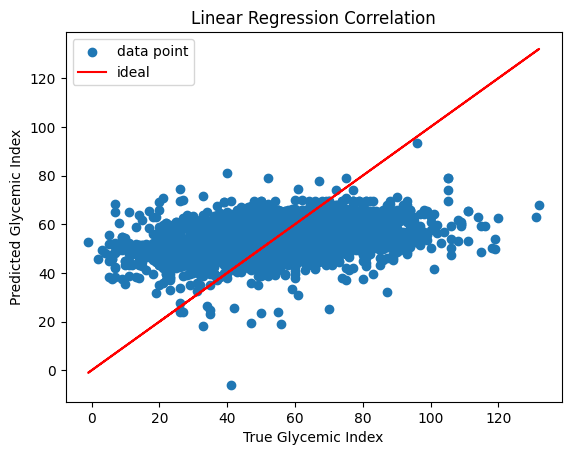

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import r_regression

reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_true = scaler.inverse_transform(y.reshape(-1,1))
print(r2_score(y_true, y_pred))
print(r_regression(y_true, y_pred))
print(np.sqrt(mean_squared_error(y_true, y_pred)))
plt.scatter(y_true.reshape(-1), y_pred.reshape(-1))
plt.plot(y_true,y_true,'r')
plt.title("Linear Regression Correlation")
plt.xlabel("True Glycemic Index")
plt.ylabel("Predicted Glycemic Index")
plt.legend(["data point", "ideal"])
plt.show()

In [8]:
class GIPredictionDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x_train=torch.tensor(x, dtype=torch.float32)
        self.y_train=torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self,idx):
        return self.x_train[idx],self.y_train[idx]

In [9]:
giDataset = GIPredictionDataset(X, y)

num_train = len(giDataset)
indices = list(range(num_train))
np.random.seed(42)
np.random.shuffle(indices)
# 70% train, 20% test, 10% validation
split1 = int(np.floor(0.3 * num_train))
split2 = int(np.floor(0.1 * num_train))
train_idx, valid_idx, test_idx = indices[split1:], indices[split2:split1], indices[:split2]

train_bs = 60
test_bs = 60

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# Create Data loaders which we will use to extract minibatches of data to input to the network for training
train_loader = torch.utils.data.DataLoader(giDataset, batch_size=train_bs,
    sampler=train_sampler, drop_last=False)
test_loader = torch.utils.data.DataLoader(giDataset, batch_size=len(test_idx),
    sampler= test_sampler, drop_last=False)
valid_loader = torch.utils.data.DataLoader(giDataset, batch_size=test_bs,
    sampler=valid_sampler, drop_last=False)


In [10]:
len(train_idx), len(valid_idx), len(test_idx)

(2626, 750, 375)

In [11]:
class RegressionModel(torch.nn.Module):

    def __init__(self, num_features, device=torch.device('cuda'), hidden_layer_dim=16, p=0.2):
        super(RegressionModel, self).__init__()
        self.hidden_layer_dim = hidden_layer_dim

        # hidden layer
        self.l1 = nn.Linear(num_features, int(64*1))
        self.l2 = nn.Linear(int(64*1), int(128*1))
        self.l3 = nn.Linear(int(128*1), int(256*1))
        self.l4 = nn.Linear(int(256*1), int(64*1))
        self.l5 = nn.Linear(int(64*1), int(32*1))
        self.l6 = nn.Linear(int(32*1), int(16*1))
        # self.l7 = nn.Linear(int(128*1), int(64*1))

        self.dropout_layer = torch.nn.Dropout(p=p).to(device)
        self.dropout_layer2 = torch.nn.Dropout(p=0.5).to(device)
        self.hidden_act = torch.nn.ReLU().to(device)
        self.bn1 = nn.BatchNorm1d(int(128*1))
        # self.bn2 = nn.BatchNorm1d(int(512*1))

        # output layer
        self.output = torch.nn.Linear(int(16*1), 1).to(device)

    def forward(self, x):
        x = self.l1(x)
        x = self.hidden_act(x)
        x = self.dropout_layer(x)

        x = self.l2(x)
        x = self.hidden_act(x)
        # x = self.bn1(x)
        x = self.dropout_layer(x)

        x = self.l3(x)
        x = self.hidden_act(x)
        x = self.dropout_layer(x)

        x = self.l4(x)
        x = self.hidden_act(x)
        # x = self.bn2(x)
        x = self.dropout_layer(x)

        x = self.l5(x)
        x = self.hidden_act(x)
        x = self.dropout_layer(x)

        x = self.l6(x)
        x = self.hidden_act(x)
        # x = self.bn1(x)
        x = self.dropout_layer(x)

        # x = self.l7(x)
        # x = self.hidden_act(x)
        # x = self.dropout_layer(x)

        y_pred = self.output(x)
        return y_pred


In [12]:
# Setting up a few learning parameters
learning_rate = 1e-4
decayRate = 0.999
epochs = 5
number_of_classes = 2

In [13]:
## First we will define an instance of the model to train
model = RegressionModel(num_features)
print(model)

#Move the model to the gpu if is_cuda
if torch.cuda.is_available():
  model = model.cuda()

criterion = nn.MSELoss()

# Initialize the Adam optimizer for the model.parameters() using the learning_rate
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# This is the learning rate scheduler. It decreases the learning rate as we approach convergence
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

RegressionModel(
  (l1): Linear(in_features=14, out_features=64, bias=True)
  (l2): Linear(in_features=64, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=256, bias=True)
  (l4): Linear(in_features=256, out_features=64, bias=True)
  (l5): Linear(in_features=64, out_features=32, bias=True)
  (l6): Linear(in_features=32, out_features=16, bias=True)
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (dropout_layer2): Dropout(p=0.5, inplace=False)
  (hidden_act): ReLU()
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output): Linear(in_features=16, out_features=1, bias=True)
)


In [14]:
# training loop
def train_model(epochs, validate=True):
    train_loss = []
    val_loss = []

    for epoch in range(epochs):
        # Iterate through the batches in the data
        training_loss = 0.0
        validation_loss = 0.0

        model.train()
        itr = 0
        for (X, labels)  in train_loader:
            if torch.cuda.is_available():
                X = X.cuda()
                labels = labels.cuda()
            y_hat = model.forward(X).squeeze()
            loss = criterion(y_hat, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            my_lr_scheduler.step()
            training_loss += loss.item()

            itr += 1
        train_loss.append(training_loss/len(train_loader))

        if validate:
            model.eval()
            with torch.no_grad():
                itr = 0
                for (X,labels)  in valid_loader:
                    if torch.cuda.is_available():
                        X = X.cuda()
                        labels = labels.cuda()
                    y_hat = model.forward(X).squeeze()
                    loss = criterion(y_hat, labels)
                    validation_loss += loss.item()

                    itr += 1
                val_loss.append(validation_loss/len(valid_loader))

    return model, train_loss, val_loss


In [15]:
start = time.time()
trained_model, train_loss, val_loss = train_model(100, validate=True)
end = time.time()
print('Time to train in seconds ',(end - start))

Time to train in seconds  16.529089212417603


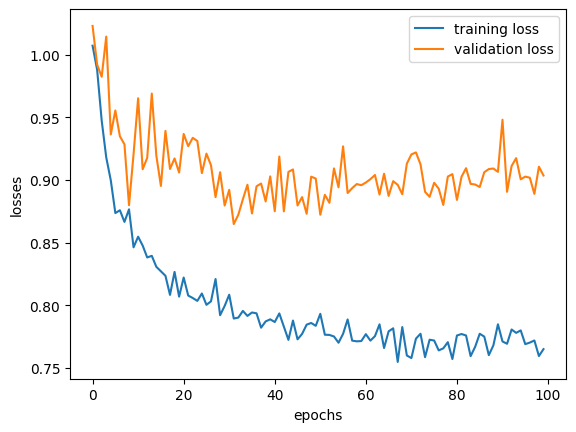

In [16]:
# Plot the losses
it = np.arange(100)
plt.plot(it, train_loss, label='training loss')
plt.plot(it, val_loss, label='validation loss')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend(loc='upper right')
plt.show()

16.769165
0.21828466062070817
[0.47730267]
[57.       40.       58.       59.       63.       39.       62.
 87.       21.999998 32.      ]
[59.940727 62.29929  61.919346 43.994358 57.785915 40.89752  58.188393
 64.49251  47.61481  35.469856]


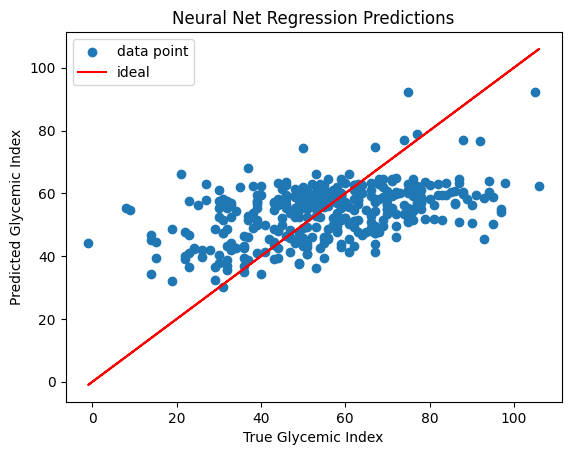

In [20]:
model.eval()
with torch.no_grad():
    for X, labels in test_loader:
        X = X.cuda()
        labels = labels.cuda()
        y_hat = model.forward(X).squeeze().cpu().numpy()
        y_hat = scaler.inverse_transform(y_hat.reshape(-1,1))
        y_hat = y_hat.reshape(-1)
        labels = labels.cpu().numpy()
        labels = scaler.inverse_transform(labels.reshape(-1,1))
        labels = labels.reshape(-1)
        print(np.sqrt(np.square(y_hat - labels).mean()))
        print(r2_score(labels, y_hat))
        print(r_regression(labels.reshape(-1,1), y_hat))
        # print(pearsonr(labels, y_hat))
        print(labels[:10], y_hat[:10], sep='\n')
plt.scatter(labels, y_hat)
# Perfect predictions
plt.plot(labels,labels,'r')
plt.title("Neural Net Regression Predictions")
plt.xlabel("True Glycemic Index")
plt.ylabel("Predicted Glycemic Index")
plt.legend(["data point", "ideal"])
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    itr = 0
    for X, labels  in valid_loader:
        if torch.cuda.is_available():
            X = X.cuda()
            labels = labels.cuda()
        y_hat = model.forward(X).squeeze()
        # loss = criterion(y_hat, labels)
        print(r2_score(labels.cpu().numpy(), y_hat.cpu().numpy()))
        print(r_regression(labels.cpu().numpy().reshape(-1,1),  y_hat.cpu().numpy()))

        # validation_loss += loss.item()

        itr += 1
    # val_loss.append(validation_loss/len(valid_loader))

0.15588209538364428
[0.47244703]
0.04493692931823112
[0.26762105]
0.14021748886526375
[0.37672856]
0.15986615635732282
[0.4201454]
0.15057920955786286
[0.3898083]
0.19389213849002096
[0.47481709]
0.19865562576292017
[0.46367418]
-0.6320449253867741
[0.17560162]
0.06586589111809849
[0.36624718]
0.10388589623595912
[0.33073472]
0.05700539061009058
[0.27069292]
0.2111210160202387
[0.4793011]
-0.0814476232254786
[0.24322349]


In [ ]:
normalizer.inverse_transform(y_hat.cpu().numpy())

AttributeError: ignored

In [ ]:
from torchmetrics.regression import PearsonCorrCoef
target = torch.tensor([3, -0.5, 2, 7])
preds = torch.tensor([2.5, 0.0, 2, 8])
pearson = PearsonCorrCoef()
pearson(preds, target)

def evaluate_model(model, loader):
    model.eval()
    # confmat = torchmetrics.ConfusionMatrix(num_classes=2)
    f1 = torchmetrics.F1Score()
    # guesses = torch.empty(0)
    # labs = torch.empty(0, dtype=int)
    with torch.no_grad():
        correct = 0
        total_samples = 0
        for X, labels in loader:
            if torch.cuda.is_available():
              X = X.cuda()
              labels = labels.cuda()
            y_hat = model.forward(X)
            guess = y_hat.argmax(axis=1)
            correct += (guess == labels).sum()
            guesses = torch.cat((guesses, guess))
            labs = torch.cat((labs, labels))
            total_samples += labels.size(0)

        accuracy = correct/total_samples*100
        return accuracy

In [ ]:
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


X, y = binary_data[combo], binary_data["over50"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=state)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
test_pred_decision_tree = clf.predict(X_test)
acc = accuracy_score(y_test, test_pred_decision_tree)
prec = precision_score(y_test, test_pred_decision_tree)
rec = recall_score(y_test, test_pred_decision_tree)
f1 = metrics.f1_score(y_test, test_pred_decision_tree)
accs.append(acc)
precs.append(prec)
recs.append(rec)
f1s.append(f1)


tensor(0.9849)